# Setup code

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Imports
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
import PIL.Image
from matplotlib import pyplot as plt
torch.manual_seed(1)
torch.cuda.manual_seed(1)
import tqdm
from torchsummary import summary
from torch.nn import init
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.models.resnet import BasicBlock # ResNet Block

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Y_path = "/content/targetdir/JPEGImages/"
X_path = "/content/targetdir/SynthOldPhotos/"
vae1_path = "/content/drive/MyDrive/model_params/model_VAE1.h5"
vae2_path = "/content/drive/MyDrive/model_params/model_VAE2.h5"
batch_size = 16 # What ever fit into gpu memory

In [3]:
import zipfile

if not os.path.isdir('targetdir/'):
  with zipfile.ZipFile(Y_path,"r") as zip_ref:
      zip_ref.extractall("targetdir")

  with zipfile.ZipFile(X_path,"r") as zip_ref:
      zip_ref.extractall("targetdir")

  # with zipfile.ZipFile("/content/drive/MyDrive/OldRealPhotos.zip","r") as zip_ref:
  #     zip_ref.extractall("targetdir")

# Data Loader / Data set

In [4]:
class XYPhotosDataset(Dataset):
    def __init__(self, y_path,x_path):
        self.x_files = [os.path.join(y_path, f) for f in sorted(os.listdir(x_path))]
        self.y_files = [os.path.join(x_path, f) for f in sorted(os.listdir(y_path))]

    def __getitem__(self, index):
        img_y=self.Read_image(self.y_files[index]);
        img_x=self.Read_image(self.x_files[index]);
        return img_y,img_x

    def Read_image(self,name):
        img = PIL.Image.open(name).convert('RGB')
        img = img.resize((256, 256))
        img = np.array(img)/255.0;
        img=np.transpose(img,(2,0,1)).astype('float32')
        return torch.tensor(img-0.5)

    def __len__(self):
      return min([len(self.y_files),len(self.x_files)])   # Need a better way, might not use some part of the data

# test data gen
data_set = XYPhotosDataset(Y_path, X_path)
img1,img2=data_set.__getitem__(0);


train_len = int(len(data_set)*0.9)
train_set, test_set = random_split(data_set, [train_len, len(data_set) - train_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False,num_workers=5)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,num_workers=5)

# Model Classes

In [5]:
class Mapping(nn.Module):
    def __init__(self, z_dim=256):
        """
        Initialize the model structure following the paper
        """
        super(Mapping, self).__init__()
        # self.dim_reshape = int(np.sqrt(z_dim))
        # Using InstanceNorm2D since it seems that is what is preferred in the paper (for facial enhancement, but still).

        # First 3 conv2d layers 
        self.conv1 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1),
                                    nn.InstanceNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 256, 3, stride=1, padding=1), 
                                    nn.InstanceNorm2d(64),
                                    nn.ReLU(), 
                                    nn.Conv2d(256, 512, 3, stride=1, padding=1), 
                                    nn.InstanceNorm2d(64),
                                    nn.ReLU()
                                    )
        
        # ResNet Blocks x 6
        self.resblocks = nn.Sequential(BasicBlock(512, 512),
                                        nn.InstanceNorm2d(64),
                                        BasicBlock(512, 512),
                                        nn.InstanceNorm2d(64),
                                        BasicBlock(512, 512),
                                        nn.InstanceNorm2d(64),
                                        BasicBlock(512, 512),
                                        nn.InstanceNorm2d(64),
                                        BasicBlock(512, 512),
                                        nn.InstanceNorm2d(64),
                                        BasicBlock(512, 512),
                                        nn.InstanceNorm2d(64),
                                       )
        
        # Second batch of conv2d layer 
        self.conv2 = nn.Sequential(nn.Conv2d(512, 256, 3, stride=1, padding=1),
                            nn.InstanceNorm2d(64),
                            nn.ReLU(),
                            nn.Conv2d(256, 128, 3, stride=1, padding=1), 
                            nn.InstanceNorm2d(64),
                            nn.ReLU(), 
                            nn.Conv2d(128, 64, 3, stride=1, padding=1), 
                            nn.InstanceNorm2d(64),
                            nn.ReLU()
                            )
        
    def forward(self, x):
        """
        Execute forward pass in the model

        Args:
            x (array-like): input of the model (here, latent space generated by VAE1 (union of Zx and Zr)) 
            Input shape: torch.Size([10, 1, 256])

        Returns:
            array-like: translated latent space to Zy
        """
        out = x
        out = self.conv1(out)
        out = self.resblocks(out)
        out = self.conv2(out)
        return out



In [6]:
# Discriminator
class ConvBNRelu(nn.Module):
    def __init__(self, nin,nout,stride=2):
        super(ConvBNRelu, self).__init__()
        self.layer=nn.Sequential(nn.Conv2d(in_channels = nin,out_channels = nout,kernel_size = 4,stride = stride,padding = 1,bias = False),
                  nn.BatchNorm2d(nout),
                  nn.LeakyReLU(0.2, inplace=True))
    def forward(self, x):
        return self.layer(x);


class Discriminator(nn.Module):
    def __init__(self,nChannels=64, ndf=64):
        super(Discriminator, self).__init__()
        # input : (batch * nChannels * image width * image height)
        # Discriminator will be consisted with a series of convolution networks
        self.ndf = ndf
        self.layer1 = ConvBNRelu(nChannels,ndf,stride=2); 
        self.layer2 =  ConvBNRelu(ndf,ndf*2,stride=2); 
        self.layer3 =  ConvBNRelu(ndf*2,ndf*4,stride=2); 
        self.layer4 =  ConvBNRelu(ndf*4,ndf*8,stride=2); 
        self.layer5 =   ConvBNRelu(ndf*8,1,stride=1); 
        self.final = nn.Conv2d(in_channels = 1,out_channels = 1,kernel_size = 1,stride = 1)

        self.layers = [self.layer1, self.layer2, self.layer3, self.layer4, self.layer5, self.final]

    def forward(self, x):
        out = self.layer1(x);
        out = self.layer2(out);
        out = self.layer3(out);
        out = self.layer4(out)
        out = self.layer5(out);
        out = self.final(out);
        return out

    def compute_perceptual_loss(self, input, target):
        x = input
        y = target
        loss = 0
        for layer in self.layers:
            x = layer(x)
            y = layer(y)
            loss += torch.nn.functional.l1_loss(x, y)

        return loss


# PERCEPTUAL LOSS FOR VGG
# source : https://gist.github.com/alper111/8233cdb0414b4cb5853f2f730ab95a49
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
        return loss

In [7]:
class ReNetBlock(nn.Module):
    def __init__(self,infil=64,outfil=64):
        super(ReNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(infil, outfil, kernel_size=3, stride=1,padding=1);
        self.bn1 =  nn.InstanceNorm2d(outfil)
        self.relu1 =  nn.ReLU(False)

        self.conv2 = nn.Conv2d(outfil, outfil, kernel_size=3, stride=1,padding=1);
        self.bn2 = nn.InstanceNorm2d(outfil)
        self.relu2 =  nn.ReLU(False)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu2(out)

        return out

class ConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=3,strides=2,pad=1):
        super(ConvBNR, self).__init__()
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad);
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation
  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)));


class TransposeConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=4,strides=2,pad=1):
        super(TransposeConvBNR, self).__init__()
        self.conv1= nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad);
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation
  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)));

class VAE1_encoder(nn.Module):
    def __init__(self,in_channels=3,n_res_blocks=4,n_layers=5):
        super(VAE1_encoder, self).__init__()
        self.n_layers=n_layers;
        self.layer=nn.ModuleList()
        self.layer1 = ConvBNR(in_channels,64,kw=7,pad=3,strides=1);
        for j in range(n_layers):
            self.layer.append(ConvBNR(64,64));

        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks;
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64,64))

    def forward(self, x):
        x=self.layer1(x)
        for j in range(self.n_layers):
          x= self.layer[j](x)

        for j in range(self.n_res_blocks):
           x=self.res_blks[j](x);
        return x

class VAE1_decoder(nn.Module):
    def __init__(self,in_channels=64,out_channel=3,n_res_blocks=4,n_layers=5):
        super(VAE1_decoder, self).__init__()
        self.n_layers=n_layers;
        self.layer=nn.ModuleList()
        for j in range(n_layers):
            self.layer.append(TransposeConvBNR(64,64,pad=1));

        #self.layer1 = TransposeConvBNR(64,out_channel,kw=7,pad=3,strides=1,activation=None);
        self.layer1 = nn.Conv2d(64, out_channel, kernel_size=1, stride=1);
        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks;
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64,64))

    def forward(self, x):
        for j in range(self.n_res_blocks):
           x=self.res_blks[j](x);
        
        for j in range(self.n_layers):
           # print(x.shape)
            x= self.layer[j](x)
        #print(x.shape)
        x=self.layer1(x);
        return x

class VAE1(nn.Module):
  def __init__(self,z_dim=256):
        super(VAE1, self).__init__()
        self.n_layers=2;
        self.down_fact=2**self.n_layers;
        down_img_size=256//self.down_fact;
        self.fdim=(down_img_size)**2*64
        print('bottle neck image resolution '+str(down_img_size))
        print('bottle neck dim is '+str(self.fdim)+'..!')
        self.size=[64,down_img_size,down_img_size]
        self.encoder=VAE1_encoder(n_layers=self.n_layers)
        self.decoder=VAE1_decoder(n_layers=self.n_layers)
        self.fc1 = nn.Linear(self.fdim, z_dim)
        self.fc2 = nn.Linear(self.fdim, z_dim)
        self.fc3 = nn.Linear(z_dim, self.fdim)
        #self.init_weights();

  def flat(self, input):
        return input.view(input.size(0),1, -1)

  def unflat(self, input):
        return input.view(input.size(0), self.size[0], self.size[1], self.size[2])

  def init_weights(self, init_type="xavier", gain=0.02):
      def init_func(m):
          classname = m.__class__.__name__
          if classname.find("BatchNorm2d") != -1:
              if hasattr(m, "weight") and m.weight is not None:
                  init.normal_(m.weight.data, 1.0, gain)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Conv") != -1):
              if init_type == "normal":
                  init.normal_(m.weight.data, 0.0, gain)
              elif init_type == "xavier":
                  init.xavier_normal_(m.weight.data, gain=gain)
              elif init_type == "xavier_uniform":
                  init.xavier_uniform_(m.weight.data, gain=1.0)
              elif init_type == "kaiming":
                  init.kaiming_normal_(m.weight.data, a=0, mode="fan_in")
              elif init_type == "orthogonal":
                  init.orthogonal_(m.weight.data, gain=gain)
              elif init_type == "none":  # uses pytorch's default init method
                  m.reset_parameters()
              else:
                  raise NotImplementedError("initialization method [%s] is not implemented" % init_type)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Linear") != -1):
              init.normal_(m.weight.data,0.0,gain)

      self.apply(init_func)
      for m in self.children():
            if hasattr(m, "init_weights"):
                m.init_weights(init_type, gain)
        
  def reparameterize(self, mu, logvar):
      std = logvar.mul(0.5).exp_()
      esp = torch.randn(*mu.size()).to(device)
      z = mu + std * esp  
      return z
  
  def bottleneck(self, h):
      mu, logvar = self.fc1(h), self.fc2(h)
      logvar=logvar*1e-3; #lazy way to stabilize the training.
      z = self.reparameterize(mu, logvar)
      return z, mu, logvar

  def encode(self, x):
      h = self.encoder(x)
      h=self.flat(h)
      z, mu, logvar = self.bottleneck(h)
      return z, mu, logvar

  def decode(self, z):
      z = self.fc3(z)
      z_img=self.unflat(z);
      z = self.decoder(z_img)
      return z,z_img

  def forward(self, x,flow='all'):
      z_latent, mu, logvar = self.encode(x)
      z,z_out = self.decode(z_latent)
      if(flow=='all'):
        return z, mu, logvar,z_out
      else:
        return z, mu, logvar,z_out,z_latent



In [8]:
class ReNetBlock(nn.Module):
    def __init__(self,infil=64,outfil=64):
        super(ReNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(infil, outfil, kernel_size=3, stride=1,padding=1);
        self.bn1 =  nn.InstanceNorm2d(outfil)
        self.relu1 =  nn.ReLU(False)

        self.conv2 = nn.Conv2d(outfil, outfil, kernel_size=3, stride=1,padding=1);
        self.bn2 = nn.InstanceNorm2d(outfil)
        self.relu2 =  nn.ReLU(False)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu2(out)

        return out

class ConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=3,strides=2,pad=1):
        super(ConvBNR, self).__init__()
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad);
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation
  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)));



class TransposeConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=4,strides=2,pad=1):
        super(TransposeConvBNR, self).__init__()
        self.conv1= nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad);
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation
  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)));

class VAE2_encoder(nn.Module):
    def __init__(self,in_channels=3,n_res_blocks=4,n_layers=5):
        super(VAE2_encoder, self).__init__()
        self.n_layers=n_layers;
        self.layer=nn.ModuleList()
        self.layer1 = ConvBNR(in_channels,64,kw=7,pad=3,strides=1);
        for j in range(n_layers):
            self.layer.append(ConvBNR(64,64));

        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks;
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64,64))

    def forward(self, x):
        x=self.layer1(x)
        for j in range(self.n_layers):
          x= self.layer[j](x)

        for j in range(self.n_res_blocks):
           x=self.res_blks[j](x);
        return x

class VAE2_decoder(nn.Module):
    def __init__(self,in_channels=64,out_channel=3,n_res_blocks=4,n_layers=5):
        super(VAE2_decoder, self).__init__()
        self.n_layers=n_layers;
        self.layer=nn.ModuleList()
        for j in range(n_layers):
            self.layer.append(TransposeConvBNR(64,64,pad=1));

        #self.layer1 = TransposeConvBNR(64,out_channel,kw=7,pad=3,strides=1,activation=None);
        self.layer1 = nn.Conv2d(64, out_channel, kernel_size=1, stride=1);
        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks;
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64,64))

    def forward(self, x):
        for j in range(self.n_res_blocks):
           x=self.res_blks[j](x);
        
        for j in range(self.n_layers):
           # print(x.shape)
            x= self.layer[j](x)
        #print(x.shape)
        x=self.layer1(x);
        return x

class VAE2(nn.Module):
  def __init__(self,z_dim=256):
        super(VAE2, self).__init__()
        self.n_layers=2;
        self.down_fact=2**self.n_layers;
        down_img_size=256//self.down_fact;
        self.fdim=(down_img_size)**2*64
        print('bottle neck image resolution '+str(down_img_size))
        print('bottle neck dim is '+str(self.fdim)+'..!')
        self.size=[64,down_img_size,down_img_size]
        self.encoder=VAE2_encoder(n_layers=self.n_layers)
        self.decoder=VAE2_decoder(n_layers=self.n_layers)
        self.fc1 = nn.Linear(self.fdim, z_dim)
        self.fc2 = nn.Linear(self.fdim, z_dim)
        self.fc3 = nn.Linear(z_dim, self.fdim)
        #self.init_weights();

  def flat(self, input):
        return input.view(input.size(0),1, -1)

  def unflat(self, input):
        return input.view(input.size(0), self.size[0], self.size[1], self.size[2])

  def init_weights(self, init_type="xavier", gain=0.02):
      def init_func(m):
          classname = m.__class__.__name__
          if classname.find("BatchNorm2d") != -1:
              if hasattr(m, "weight") and m.weight is not None:
                  init.normal_(m.weight.data, 1.0, gain)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Conv") != -1):
              if init_type == "normal":
                  init.normal_(m.weight.data, 0.0, gain)
              elif init_type == "xavier":
                  init.xavier_normal_(m.weight.data, gain=gain)
              elif init_type == "xavier_uniform":
                  init.xavier_uniform_(m.weight.data, gain=1.0)
              elif init_type == "kaiming":
                  init.kaiming_normal_(m.weight.data, a=0, mode="fan_in")
              elif init_type == "orthogonal":
                  init.orthogonal_(m.weight.data, gain=gain)
              elif init_type == "none":  # uses pytorch's default init method
                  m.reset_parameters()
              else:
                  raise NotImplementedError("initialization method [%s] is not implemented" % init_type)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Linear") != -1):
              init.normal_(m.weight.data,0.0,gain)

      self.apply(init_func)
      for m in self.children():
            if hasattr(m, "init_weights"):
                m.init_weights(init_type, gain)
        
  def reparameterize(self, mu, logvar):
      std = logvar.mul(0.5).exp_()
      esp = torch.randn(*mu.size()).to(device)
      z = mu + std * esp  
      return z
  
  def bottleneck(self, h):
      mu, logvar = self.fc1(h), self.fc2(h)
      logvar=logvar*1e-3; #lazy way to stabilize the training.
      z = self.reparameterize(mu, logvar)
      return z, mu, logvar

  def encode(self, x):
      h = self.encoder(x)
      h=self.flat(h)
      z, mu, logvar = self.bottleneck(h)
      return z, mu, logvar

  def decode(self, z):
      z = self.fc3(z)
      z_img=self.unflat(z);
      z = self.decoder(z_img)
      return z,z_img

  def forward(self, x,flow='all'):
      z_latent, mu, logvar = self.encode(x)
      z,z_out = self.decode(z_latent)
      if(flow=='all'):
        return z, mu, logvar,z_out
      else:
        return z, mu, logvar,z_out,z_latent

# Training / Testing code

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


bottle neck image resolution 64
bottle neck dim is 262144..!
bottle neck image resolution 64
bottle neck dim is 262144..!








Currently on epoch 0, training: 100%|██████████| 964/964 [10:10<00:00,  1.79batch/s]




















Currently on epoch 0, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 0 Average mapping loss: 0.0020



Testing model...: 0batch [00:00, ?batch/s]

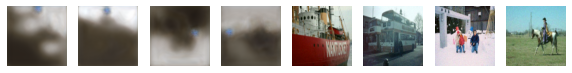

Testing model...: 107batch [00:34,  3.90batch/s]














Testing model...: 108batch [00:34,  3.13batch/s]


====> Test set loss_mapping: 2.1980
Saving model for epoch 0






Currently on epoch 1, training: 100%|██████████| 964/964 [10:10<00:00,  1.79batch/s]









Currently on epoch 1, training: 100%|██████████| 964/964 [10:11<00:00,  1.58batch/s]

====> Epoch: 1 Average mapping loss: 0.0020



Testing model...: 107batch [00:32,  3.94batch/s]





Testing model...: 108batch [00:32,  3.33batch/s]


====> Test set loss_mapping: 2.0474
Saving model for epoch 1




Currently on epoch 2, training: 100%|██████████| 964/964 [10:11<00:00,  1.80batch/s]


Currently on epoch 2, training: 100%|██████████| 964/964 [10:11<00:00,  1.58batch/s]

====> Epoch: 2 Average mapping loss: 0.0019



Testing model...: 107batch [00:32,  3.96batch/s]
Testing model...: 108batch [00:32,  3.31batch/s]


====> Test set loss_mapping: 1.9888
Saving model for epoch 2


Currently on epoch 3, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 3 Average mapping loss: 0.0019



Testing model...: 108batch [00:32,  3.35batch/s]


====> Test set loss_mapping: 1.9607
Saving model for epoch 3


Currently on epoch 4, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 4 Average mapping loss: 0.0018



Testing model...: 108batch [00:31,  3.38batch/s]


====> Test set loss_mapping: 1.8768
Saving model for epoch 4


Currently on epoch 5, training: 100%|██████████| 964/964 [10:11<00:00,  1.58batch/s]

====> Epoch: 5 Average mapping loss: 0.0018



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

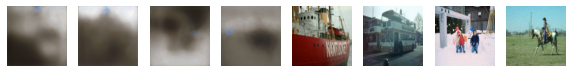

Testing model...: 108batch [00:32,  3.29batch/s]


====> Test set loss_mapping: 1.8527
Saving model for epoch 5


Currently on epoch 6, training: 100%|██████████| 964/964 [10:11<00:00,  1.58batch/s]

====> Epoch: 6 Average mapping loss: 0.0018



Testing model...: 108batch [00:32,  3.36batch/s]


====> Test set loss_mapping: 1.8302
Saving model for epoch 6


Currently on epoch 7, training: 100%|██████████| 964/964 [10:11<00:00,  1.58batch/s]

====> Epoch: 7 Average mapping loss: 0.0018



Testing model...: 108batch [00:32,  3.34batch/s]


====> Test set loss_mapping: 1.8115
Saving model for epoch 7


Currently on epoch 8, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 8 Average mapping loss: 0.0018



Testing model...: 108batch [00:32,  3.36batch/s]


====> Test set loss_mapping: 1.7866
Saving model for epoch 8


Currently on epoch 9, training: 100%|██████████| 964/964 [10:11<00:00,  1.58batch/s]

====> Epoch: 9 Average mapping loss: 0.0017



Testing model...: 108batch [00:31,  3.38batch/s]


====> Test set loss_mapping: 1.7732
Saving model for epoch 9


Currently on epoch 10, training: 100%|██████████| 964/964 [10:11<00:00,  1.58batch/s]

====> Epoch: 10 Average mapping loss: 0.0017



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

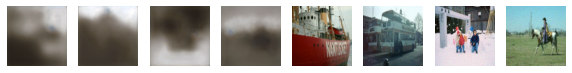

Testing model...: 108batch [00:32,  3.28batch/s]


====> Test set loss_mapping: 1.7715
Saving model for epoch 10


Currently on epoch 11, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 11 Average mapping loss: 0.0017



Testing model...: 108batch [00:32,  3.36batch/s]


====> Test set loss_mapping: 1.7563
Saving model for epoch 11


Currently on epoch 12, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 12 Average mapping loss: 0.0017



Testing model...: 108batch [00:32,  3.36batch/s]


====> Test set loss_mapping: 1.7440
Saving model for epoch 12


Currently on epoch 13, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 13 Average mapping loss: 0.0017



Testing model...: 108batch [00:32,  3.36batch/s]


====> Test set loss_mapping: 1.7646
Saving model for epoch 13


Currently on epoch 14, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 14 Average mapping loss: 0.0017



Testing model...: 108batch [00:31,  3.42batch/s]


====> Test set loss_mapping: 1.7364
Saving model for epoch 14


Currently on epoch 15, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 15 Average mapping loss: 0.0017



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

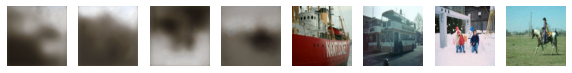

Testing model...: 108batch [00:32,  3.37batch/s]


====> Test set loss_mapping: 1.7173
Saving model for epoch 15


Currently on epoch 16, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 16 Average mapping loss: 0.0017



Testing model...: 108batch [00:30,  3.49batch/s]


====> Test set loss_mapping: 1.7207
Saving model for epoch 16


Currently on epoch 17, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 17 Average mapping loss: 0.0017



Testing model...: 108batch [00:31,  3.44batch/s]


====> Test set loss_mapping: 1.7144
Saving model for epoch 17


Currently on epoch 18, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 18 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.44batch/s]


====> Test set loss_mapping: 1.7032
Saving model for epoch 18


Currently on epoch 19, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 19 Average mapping loss: 0.0017



Testing model...: 108batch [00:31,  3.42batch/s]


====> Test set loss_mapping: 1.6992
Saving model for epoch 19


Currently on epoch 20, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 20 Average mapping loss: 0.0017



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

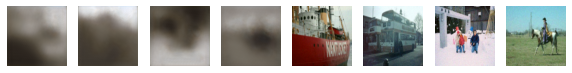

Testing model...: 108batch [00:32,  3.32batch/s]


====> Test set loss_mapping: 1.6941
Saving model for epoch 20


Currently on epoch 21, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 21 Average mapping loss: 0.0017



Testing model...: 108batch [00:31,  3.43batch/s]


====> Test set loss_mapping: 1.6929
Saving model for epoch 21


Currently on epoch 22, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]


====> Epoch: 22 Average mapping loss: 0.0016


Testing model...: 108batch [00:31,  3.43batch/s]


====> Test set loss_mapping: 1.6828
Saving model for epoch 22


Currently on epoch 23, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 23 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.44batch/s]


====> Test set loss_mapping: 1.6844
Saving model for epoch 23


Currently on epoch 24, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 24 Average mapping loss: 0.0017



Testing model...: 108batch [00:31,  3.42batch/s]


====> Test set loss_mapping: 1.7328
Saving model for epoch 24


Currently on epoch 25, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 25 Average mapping loss: 0.0016



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

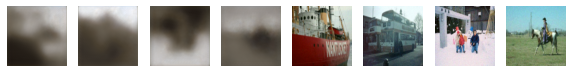

Testing model...: 108batch [00:32,  3.34batch/s]


====> Test set loss_mapping: 1.6858
Saving model for epoch 25


Currently on epoch 26, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 26 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.40batch/s]


====> Test set loss_mapping: 1.6791
Saving model for epoch 26


Currently on epoch 27, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 27 Average mapping loss: 0.0017



Testing model...: 108batch [00:31,  3.43batch/s]


====> Test set loss_mapping: 1.6742
Saving model for epoch 27


Currently on epoch 28, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 28 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.38batch/s]


====> Test set loss_mapping: 1.6799
Saving model for epoch 28


Currently on epoch 29, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]


====> Epoch: 29 Average mapping loss: 0.0016


Testing model...: 108batch [00:31,  3.40batch/s]


====> Test set loss_mapping: 1.6718
Saving model for epoch 29


Currently on epoch 30, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 30 Average mapping loss: 0.0016



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

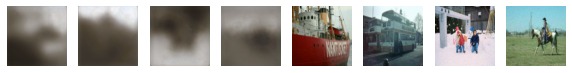

Testing model...: 108batch [00:32,  3.32batch/s]


====> Test set loss_mapping: 1.6857
Saving model for epoch 30


Currently on epoch 31, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]


====> Epoch: 31 Average mapping loss: 0.0017


Testing model...: 108batch [00:31,  3.39batch/s]


====> Test set loss_mapping: 1.6848
Saving model for epoch 31


Currently on epoch 32, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 32 Average mapping loss: 0.0017



Testing model...: 108batch [00:31,  3.45batch/s]


====> Test set loss_mapping: 1.6732
Saving model for epoch 32


Currently on epoch 33, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 33 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.41batch/s]


====> Test set loss_mapping: 1.6768
Saving model for epoch 33


Currently on epoch 34, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 34 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.36batch/s]


====> Test set loss_mapping: 1.6911
Saving model for epoch 34


Currently on epoch 35, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 35 Average mapping loss: 0.0017



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

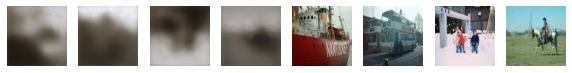

Testing model...: 108batch [00:33,  3.27batch/s]


====> Test set loss_mapping: 1.6821
Saving model for epoch 35


Currently on epoch 36, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 36 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.39batch/s]


====> Test set loss_mapping: 1.6847
Saving model for epoch 36


Currently on epoch 37, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 37 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.36batch/s]


====> Test set loss_mapping: 1.6743
Saving model for epoch 37


Currently on epoch 38, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]


====> Epoch: 38 Average mapping loss: 0.0016


Testing model...: 108batch [00:31,  3.38batch/s]


====> Test set loss_mapping: 1.6819
Saving model for epoch 38


Currently on epoch 39, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 39 Average mapping loss: 0.0017



Testing model...: 108batch [00:32,  3.37batch/s]


====> Test set loss_mapping: 1.7154
Saving model for epoch 39


Currently on epoch 40, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]


====> Epoch: 40 Average mapping loss: 0.0016


Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

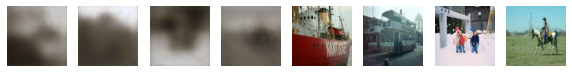

Testing model...: 108batch [00:32,  3.35batch/s]


====> Test set loss_mapping: 1.6645
Saving model for epoch 40


Currently on epoch 41, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 41 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.40batch/s]


====> Test set loss_mapping: 1.6772
Saving model for epoch 41


Currently on epoch 42, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 42 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.43batch/s]


====> Test set loss_mapping: 1.6639
Saving model for epoch 42


Currently on epoch 43, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 43 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.46batch/s]


====> Test set loss_mapping: 1.6661
Saving model for epoch 43


Currently on epoch 44, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 44 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.44batch/s]


====> Test set loss_mapping: 1.6568
Saving model for epoch 44


Currently on epoch 45, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 45 Average mapping loss: 0.0016



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

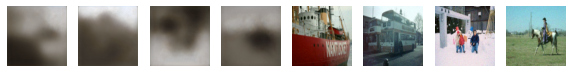

Testing model...: 108batch [00:32,  3.33batch/s]


====> Test set loss_mapping: 1.6567
Saving model for epoch 45


Currently on epoch 46, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 46 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.37batch/s]


====> Test set loss_mapping: 1.6594
Saving model for epoch 46


Currently on epoch 47, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 47 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.35batch/s]


====> Test set loss_mapping: 1.6642
Saving model for epoch 47


Currently on epoch 48, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 48 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.36batch/s]


====> Test set loss_mapping: 1.6726
Saving model for epoch 48


Currently on epoch 49, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 49 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.40batch/s]


====> Test set loss_mapping: 1.6712
Saving model for epoch 49


Currently on epoch 50, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 50 Average mapping loss: 0.0016



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

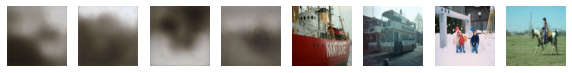

Testing model...: 108batch [00:32,  3.29batch/s]


====> Test set loss_mapping: 1.6579
Saving model for epoch 50


Currently on epoch 51, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 51 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.38batch/s]


====> Test set loss_mapping: 1.6564
Saving model for epoch 51


Currently on epoch 52, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 52 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.38batch/s]


====> Test set loss_mapping: 1.6536
Saving model for epoch 52


Currently on epoch 53, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 53 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.46batch/s]


====> Test set loss_mapping: 1.6648
Saving model for epoch 53


Currently on epoch 54, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 54 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.38batch/s]


====> Test set loss_mapping: 1.6554
Saving model for epoch 54


Currently on epoch 55, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]


====> Epoch: 55 Average mapping loss: 0.0016


Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

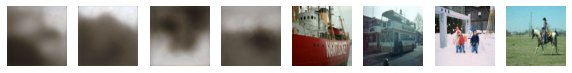

Testing model...: 108batch [00:32,  3.30batch/s]


====> Test set loss_mapping: 1.6520
Saving model for epoch 55


Currently on epoch 56, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]


====> Epoch: 56 Average mapping loss: 0.0016


Testing model...: 108batch [00:31,  3.44batch/s]


====> Test set loss_mapping: 1.6755
Saving model for epoch 56


Currently on epoch 57, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 57 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.44batch/s]


====> Test set loss_mapping: 1.6608
Saving model for epoch 57


Currently on epoch 58, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 58 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.48batch/s]


====> Test set loss_mapping: 1.6496
Saving model for epoch 58


Currently on epoch 59, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 59 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.46batch/s]


====> Test set loss_mapping: 1.6530
Saving model for epoch 59


Currently on epoch 60, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 60 Average mapping loss: 0.0016



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

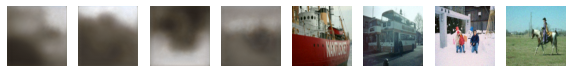

Testing model...: 108batch [00:32,  3.32batch/s]


====> Test set loss_mapping: 1.6584
Saving model for epoch 60


Currently on epoch 61, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 61 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.44batch/s]


====> Test set loss_mapping: 1.6548
Saving model for epoch 61


Currently on epoch 62, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 62 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.44batch/s]


====> Test set loss_mapping: 1.6521
Saving model for epoch 62


Currently on epoch 63, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 63 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.42batch/s]


====> Test set loss_mapping: 1.6893
Saving model for epoch 63


Currently on epoch 64, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]


====> Epoch: 64 Average mapping loss: 0.0016


Testing model...: 108batch [00:31,  3.48batch/s]


====> Test set loss_mapping: 1.6503
Saving model for epoch 64


Currently on epoch 65, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 65 Average mapping loss: 0.0016



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

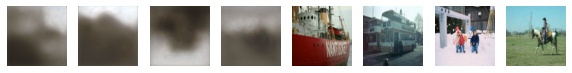

Testing model...: 108batch [00:31,  3.42batch/s]


====> Test set loss_mapping: 1.6672
Saving model for epoch 65


Currently on epoch 66, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 66 Average mapping loss: 0.0015



Testing model...: 108batch [00:31,  3.47batch/s]


====> Test set loss_mapping: 1.6492
Saving model for epoch 66


Currently on epoch 67, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 67 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.47batch/s]


====> Test set loss_mapping: 1.6483
Saving model for epoch 67


Currently on epoch 68, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 68 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.43batch/s]


====> Test set loss_mapping: 1.6518
Saving model for epoch 68


Currently on epoch 69, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 69 Average mapping loss: 0.0016



Testing model...: 108batch [00:30,  3.49batch/s]


====> Test set loss_mapping: 1.6618
Saving model for epoch 69


Currently on epoch 70, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 70 Average mapping loss: 0.0016



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

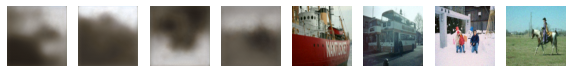

Testing model...: 108batch [00:32,  3.31batch/s]


====> Test set loss_mapping: 1.6652
Saving model for epoch 70


Currently on epoch 71, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 71 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.43batch/s]


====> Test set loss_mapping: 1.6512
Saving model for epoch 71


Currently on epoch 72, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 72 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.40batch/s]


====> Test set loss_mapping: 1.6496
Saving model for epoch 72


Currently on epoch 73, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 73 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.45batch/s]


====> Test set loss_mapping: 1.6578
Saving model for epoch 73


Currently on epoch 74, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 74 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.40batch/s]


====> Test set loss_mapping: 1.6471
Saving model for epoch 74


Currently on epoch 75, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 75 Average mapping loss: 0.0016



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

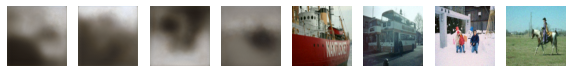

Testing model...: 108batch [00:32,  3.34batch/s]


====> Test set loss_mapping: 1.6527
Saving model for epoch 75


Currently on epoch 76, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 76 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.42batch/s]


====> Test set loss_mapping: 1.6502
Saving model for epoch 76


Currently on epoch 77, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 77 Average mapping loss: 0.0016



Testing model...: 108batch [00:31,  3.38batch/s]


====> Test set loss_mapping: 1.6445
Saving model for epoch 77


Currently on epoch 78, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 78 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.35batch/s]


====> Test set loss_mapping: 1.6461
Saving model for epoch 78


Currently on epoch 79, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 79 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.33batch/s]


====> Test set loss_mapping: 1.6542
Saving model for epoch 79


Currently on epoch 80, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 80 Average mapping loss: 0.0016



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

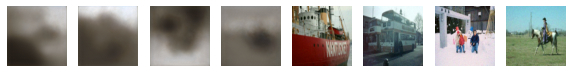

Testing model...: 108batch [00:33,  3.23batch/s]


====> Test set loss_mapping: 1.6460
Saving model for epoch 80


Currently on epoch 81, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 81 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.35batch/s]


====> Test set loss_mapping: 1.6399
Saving model for epoch 81


Currently on epoch 82, training: 100%|██████████| 964/964 [10:11<00:00,  1.58batch/s]

====> Epoch: 82 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.37batch/s]


====> Test set loss_mapping: 1.6484
Saving model for epoch 82


Currently on epoch 83, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 83 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.35batch/s]


====> Test set loss_mapping: 1.6502
Saving model for epoch 83


Currently on epoch 84, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]


====> Epoch: 84 Average mapping loss: 0.0016


Testing model...: 108batch [00:32,  3.34batch/s]


====> Test set loss_mapping: 1.6515
Saving model for epoch 84


Currently on epoch 85, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 85 Average mapping loss: 0.0016



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

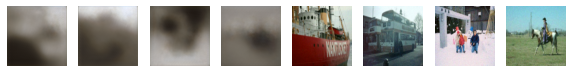

Testing model...: 108batch [00:33,  3.26batch/s]


====> Test set loss_mapping: 1.6503
Saving model for epoch 85


Currently on epoch 86, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 86 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.35batch/s]


====> Test set loss_mapping: 1.6426
Saving model for epoch 86


Currently on epoch 87, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]


====> Epoch: 87 Average mapping loss: 0.0016


Testing model...: 108batch [00:32,  3.33batch/s]


====> Test set loss_mapping: 1.6529
Saving model for epoch 87


Currently on epoch 88, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 88 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.33batch/s]


====> Test set loss_mapping: 1.6482
Saving model for epoch 88


Currently on epoch 89, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 89 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.34batch/s]


====> Test set loss_mapping: 1.6439
Saving model for epoch 89


Currently on epoch 90, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 90 Average mapping loss: 0.0016



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

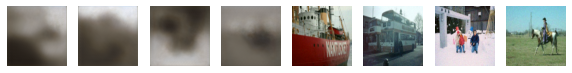

Testing model...: 108batch [00:33,  3.22batch/s]


====> Test set loss_mapping: 1.6416
Saving model for epoch 90


Currently on epoch 91, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 91 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.35batch/s]


====> Test set loss_mapping: 1.6448
Saving model for epoch 91


Currently on epoch 92, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 92 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.34batch/s]


====> Test set loss_mapping: 1.6382
Saving model for epoch 92


Currently on epoch 93, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 93 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.32batch/s]


====> Test set loss_mapping: 1.6635
Saving model for epoch 93


Currently on epoch 94, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 94 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.33batch/s]


====> Test set loss_mapping: 1.6381
Saving model for epoch 94


Currently on epoch 95, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 95 Average mapping loss: 0.0016



Testing model...: 0batch [00:00, ?batch/s]

<Figure size 720x576 with 0 Axes>

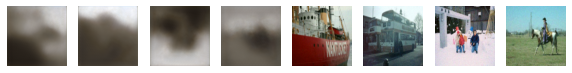

Testing model...: 108batch [00:33,  3.24batch/s]


====> Test set loss_mapping: 1.6486
Saving model for epoch 95


Currently on epoch 96, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 96 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.32batch/s]


====> Test set loss_mapping: 1.6439
Saving model for epoch 96


Currently on epoch 97, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 97 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.34batch/s]


====> Test set loss_mapping: 1.6419
Saving model for epoch 97


Currently on epoch 98, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 98 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.35batch/s]


====> Test set loss_mapping: 1.6448
Saving model for epoch 98


Currently on epoch 99, training: 100%|██████████| 964/964 [10:10<00:00,  1.58batch/s]

====> Epoch: 99 Average mapping loss: 0.0016



Testing model...: 108batch [00:32,  3.35batch/s]


====> Test set loss_mapping: 1.6414
Saving model for epoch 99


Training model...: 100%|██████████| 100/100 [17:52:47<00:00, 643.68s/it]


<Figure size 720x576 with 0 Axes>

In [13]:
vgg = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=True).to(device)
# torch.autograd.set_detect_anomaly(True)


lambda_1 = 60
lambda_2 = 10
learning_rate = 1e-4

save_dir = "/content/drive/MyDrive/projet/"


disc = Discriminator(nChannels=3,ndf=64).to(device)
vae1 = VAE1()
vae2 = VAE2().to(device)
vae1_state_dict = torch.load(vae1_path)
vae2_state_dict = torch.load(vae2_path)
vae1.load_state_dict(vae1_state_dict)
vae2.load_state_dict(vae2_state_dict)
vae1_enc_net = vae1.encoder.to(device)

for param in vae1.parameters():
    param.requires_grad = False
for param in vae2.parameters():
    param.requires_grad = False
for param in vae1_enc_net.parameters():
    param.requires_grad = False

vae1.eval()
vae2.eval()
vae1_enc_net.eval()

mapping_net = Mapping().to(device)

# Aucune indication sur comment train le discriminant, donc on y va comme cela
optim_mapping = torch.optim.Adam(list(mapping_net.parameters()) + list(disc.parameters()), lr=learning_rate, betas=(0.5, 0.999))

epochs = 100

mae_loss = nn.L1Loss().to(device)
perceptual_loss = VGGPerceptualLoss().to(device)
for epoch in tqdm.tqdm(range(0, epochs), desc="Training model..."):
    mapping_net.train()
    disc.train()
    for sample_y, sample_x in tqdm.tqdm(train_loader, desc=f"Currently on epoch {epoch}, training", unit="batch", position=0, leave=True):
        sample_y = sample_y.to(device)
        sample_x = sample_x.to(device)

        # Prendre image synthethique, envoyer dans VAE1 encodeur (donne Z_x)
        Z_x = vae1_enc_net(sample_x)
        # Prendre image encodee (Z_x), envoyer dans le mapping (donne Z_x->y)
        Z_x_y = mapping_net(Z_x)
        # Prendre la traduction (Z_x->y), l'envoyer dans le G_y (donne X_x->y)
        X_x_y = vae2.decoder(Z_x_y)
        # Prendre l'image originale, l'envoyer dans l'encodeur de VAE 2 pour obtenir Z_y
        Z_y = vae2.encoder(sample_y)
        # Prendre l'image originale (y), la passer dans VAE2 (donne Y_y->y)
        Y_y_y, _, _, _ = vae2(sample_y)

        # COMPUTE LOSSES
        # Calculer l1_loss avec Zx->y et Zy
        l1loss = mae_loss(Z_x_y, Z_y)
        # Calculer la LSGAN Loss 
        lsgan_loss = torch.mean(disc(X_x_y)**2) + torch.mean(1 - disc(Y_y_y)**2)
        # Calculer la FM loss
        vgg_loss = perceptual_loss(X_x_y, Y_y_y)
        disc_perc_loss = disc.compute_perceptual_loss(X_x_y, Y_y_y)
        fm_loss = torch.mean(disc_perc_loss + vgg_loss)

        mapping_loss = lambda_1 * l1loss + lsgan_loss + lambda_2 * fm_loss
        
        # Faire backward et step, reinitialiser le gradient.
        optim_mapping.zero_grad()
        mapping_loss.backward()
        optim_mapping.step()

    print(f'====> Epoch: {epoch} Average mapping loss: {mapping_loss / len(train_loader.dataset):.4f}')

    with torch.no_grad():
        mapping_net.eval()
        disc.eval()
        test_loss_mapping = 0
        test_loss_disc = 0
        for ix,(sample_y, sample_x) in tqdm.tqdm(enumerate(test_loader), desc="Testing model...", unit="batch", position=0, leave=True):
            sample_y = sample_y.to(device)
            sample_x = sample_x.to(device)
            
            # Prendre image synthethique, envoyer dans VAE1 encodeur (donne Z_x)
            Z_x=vae1_enc_net(sample_x);
            # Prendre image encodee (Z_x), envoyer dans le mapping (donne Z_x->y)
            Z_x_y = mapping_net(Z_x)
            # Prendre la traduction (Z_x->y), l'envoyer dans le G_y (donne X_x->y)
            X_x_y = vae2.decoder(Z_x_y)
            # Prendre l'image originale, l'envoyer dans l'encodeur de VAE 2 pour obtenir Z_y
            Z_y = vae2.encoder(sample_y)
            # Prendre l'image originale (y), la passer dans VAE2 (donne Y_y->y)
            Y_y_y, _, _, _ = vae2(sample_y)

            # COMPUTE LOSSES
            # Calculer l1_loss avec Zx->y et Zy
            l1loss = mae_loss(Z_x_y, Z_y)
            # Calculer la LSGAN Loss 
            lsgan_loss = torch.mean(disc(X_x_y)**2) + torch.mean(1 - disc(Y_y_y)**2)
            # Calculer la FM loss
            vgg_loss = perceptual_loss(X_x_y, Y_y_y)
            disc_loss = disc.compute_perceptual_loss(X_x_y, Y_y_y)

            fm_loss = torch.mean(disc_loss + vgg_loss)

            mapping_loss = lambda_1 * l1loss + lsgan_loss + lambda_2 * fm_loss

            test_loss_mapping += mapping_loss.item();


            if(ix<1 and epoch%5==0):
              plt.figure(figsize=(10, 8))
              #plt.suptitle('real test data / reconstructions')
              for i in range(4):
                  plt.subplot(1,8,i+1)
                  plt.imshow(np.clip(X_x_y.detach().cpu().numpy()[i,:,:,:].transpose(1,2,0)+0.5,0.0,1.0))
                  plt.axis('off')

              for i in range(4):
                  plt.subplot(1,8,i+1+4)
                  plt.imshow(np.clip(sample_y.detach().cpu().numpy()[i,:,:].transpose(1,2,0)+0.5,0.0,1.0))
                  plt.axis('off')
              plt.show()

              plt.figure(figsize=(10, 8))

    test_loss_mapping /= len(test_loader.dataset)
    print(f'====> Test set loss_mapping: {test_loss_mapping:.4f}')
    print(f"Saving model for epoch {epoch}")
    torch.save(mapping_net.state_dict(), save_dir + f"mapping_{epoch}_testloss_{test_loss_mapping}.h5")
    torch.save(disc.state_dict(), save_dir + f"discriminator_{epoch}_testloss_{test_loss_mapping}.h5")

In [14]:
torch.save(mapping_net.state_dict(), "./drive/MyDrive/model_params/model_mapping.h5")